In [1]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt


In [82]:
from flask.json import jsonify
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [116]:

df = pd.read_csv("ticker_data.csv")
df_close = df[["close"]]
df_close_values = df_close.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(df_close) * .95 ))

training_data_len

1196

In [117]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df_close_values)

scaled_data

array([[0.433663  ],
       [0.42228028],
       [0.43039746],
       ...,
       [0.93580892],
       [0.90819183],
       [0.91938795]])

In [118]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.433663  , 0.42228028, 0.43039746, 0.43720843, 0.44224669,
       0.43823475, 0.44933756, 0.39550289, 0.40641911, 0.39354357,
       0.40735212, 0.40306027, 0.39121105, 0.39848852, 0.39494309,
       0.4058593 , 0.40847173, 0.39979474, 0.4056727 , 0.40688561,
       0.38244075, 0.38561299, 0.36191454, 0.36172793, 0.32692667,
       0.34381414, 0.35351745, 0.36667289, 0.35277104, 0.35995522,
       0.37180444, 0.37087143, 0.33560366, 0.33457735, 0.31834297,
       0.311532  , 0.31041239, 0.28746035, 0.29884307, 0.33821609,
       0.32757977, 0.33411084, 0.34381414, 0.35650308, 0.36732599,
       0.35771599, 0.36564658, 0.36023512, 0.3584624 , 0.37115133,
       0.3774025 , 0.39317037, 0.3963426 , 0.39764882, 0.38887852,
       0.39027804, 0.39027804, 0.38477328, 0.40240717, 0.4053928 ])]
[0.4172420227654412]

[array([0.433663  , 0.42228028, 0.43039746, 0.43720843, 0.44224669,
       0.43823475, 0.44933756, 0.39550289, 0.40641911, 0.39354357,
       0.40735212, 0.40306027, 0.391

In [119]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

c:\Users\mabro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1136/1136 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0043


In [120]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = df_close_values[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


4.1530561556874215

C:\Users\mabro\AppData\Local\Temp\ipykernel_4524\2340750745.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


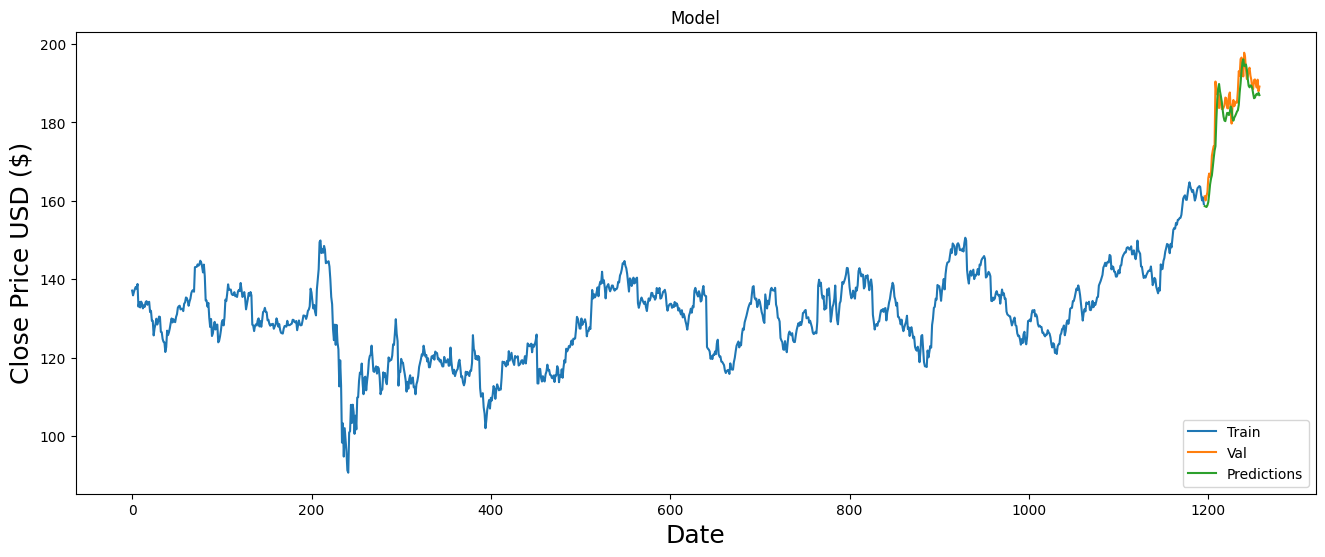

In [124]:
# Plot the data
train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [123]:
df

,Unnamed: 0,adjClose,change,changeOverTime,changePercent,close,date,high,label,low,open,unadjustedVolume,volume,vwap
0,0,107.68,0.35,0.002560,0.255980,137.08,2019-04-08,137.11,"April 08, 19",136.59,136.73,2215637,2215637,136.9300
1,1,106.72,-0.53,-0.003886,-0.388590,135.86,2019-04-09,136.66,"April 09, 19",135.60,136.39,3178271,3178271,136.0400
2,2,107.40,0.78,0.005737,0.573740,136.73,2019-04-10,137.19,"April 10, 19",135.74,135.95,2801188,2801188,136.5500
3,3,107.97,-0.02,-0.000145,-0.014548,137.46,2019-04-11,137.77,"April 11, 19",136.74,137.48,3077332,3077332,137.3200
4,4,108.40,0.08,0.000580,0.058005,138.00,2019-04-12,138.09,"April 12, 19",137.38,137.92,3032249,3032249,137.8200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,1253,189.83,-0.17,-0.000895,-0.089474,189.83,2024-04-01,190.46,"April 01, 24",188.52,190.00,2364320,2364320,189.7025
1254,1254,188.88,-0.26,-0.001375,-0.137460,188.88,2024-04-02,189.80,"April 02, 24",187.60,189.14,2693455,2693455,188.8550
1255,1255,190.90,2.30,0.012200,1.220000,190.90,2024-04-03,191.35,"April 03, 24",188.49,188.60,2826193,2826193,189.8350
1256,1256,187.94,-4.06,-0.021100,-2.110000,187.94,2024-04-04,193.28,"April 04, 24",187.34,192.00,2983853,2983853,190.1400
